# 4. Cost Benefit Analysis

In this notebook, we take a look at some simple cost-benefit analysis to determine the effectiveness and feasibility of the outputs of the model.

## 4.1 Data Imports and Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re


%matplotlib inline
plt.style.use('seaborn')

In this notebook, we will use the prediction results to establish the basis for our Cost Benefit Analysis (CBA). We will also bring in some external data, primiarily spray costs, healthcare costs, and also some relevant numbers for the purposes of estimating the costs of the West Nile Virus (WNV).

In [ ]:
pred_test = pd.read_csv("../../datasets/cleaned_data/predicted_test.csv")
hood_trap = pd.read_csv("../../datasets/original_data/train.csv")
col_to_drop = ['Date','Species','Block','Street','Latitude', 'Longitude',
 'AddressAccuracy','NumMosquitos', 'WnvPresent']
hood_trap = hood_trap.drop(columns = col_to_drop)
hood_trap = hood_trap.drop_duplicates(ignore_index = True)
reg_feat = pd.read_csv("../../datasets/cleaned_data/regression_feature_impt.csv")
class_feat = pd.read_csv("../../datasets/cleaned_data/classification_feature_impt.csv")

# https://simplemaps.com/data/us-zips
# updated march 2022
uszips = pd.read_csv("../../datasets/wnv_external_data/uszips.csv")
uszips = uszips[['zip','population','density']]
uszips['area'] = uszips['population'] / uszips['density'] * 247.105
uszips['zip'] = uszips['zip'].map(str)

### 4.1.1 Obtaining Zip Codes from Address
To estimate the risk posed to the neighbourhood, we are interested in obtaining the population in the vicinity of the trap. We have sourced for a data set which includes the population numbers, population density, and also the corresponding zip codes. A simple regex expression was used to extract the zip code from the address.


While the data provided from Kaggle was largely sufficient, there were some rows where zipcodes were not present. As a result, these rows were manually imputed using a manual search process on Google Maps to make a guess on the zip codes based on the addresses provided.

<i>Note: While it is not desirable to hardcode, the number of zip codes were relatively small, and hence worth the effort.</i>

In [ ]:
def get_zip(row):
    temp_str = re.findall('\d{5}',row)
    if len(temp_str) == 0:
        if row == 'South Vincennes Avenue, Chicago, IL, USA':
            return '60620'
        elif row == 'Chicago, IL, USA':
            return '60613'
        elif row == '6400 West Strong Street, Chicago, IL, USA':
            return '60630'
        elif row == 'South Doty Avenue, Chicago, IL, USA':
            return '60628'
        elif row == 'South Stony Island Avenue, Chicago, IL, USA':
            return '60617'
        elif row == 'South Torrence Avenue, Chicago, IL, USA':
            return '60617'
        elif row == 'East 91st Street, Chicago, IL, USA':
            return '60619'
        elif row == 'South Cottage Grove Avenue, Chicago, IL, USA':
            return '60619'
        elif row == 'West 37th Place, Chicago, IL, USA':
            return '60609'
        elif row == 'East 91st Place, Chicago, IL, USA':
            return '60619'
        elif row == 'West Garfield Boulevard, Chicago, IL, USA':
            return '60621'
        elif row == 'South Wallace Street, Chicago, IL, USA':
            return '60620'
    else:
        return temp_str[0]

hood_trap['zip'] = hood_trap['Address'].map(get_zip)

### 4.1.2 Grouping features by categories

To better visualize the relative importance of the features, we will create a column where the relative feature importance are summed up, and a general category for each feature is indicated.

In [ ]:
def feat_impt_class(row):
    temp_str = row.split("_")[0]
    if temp_str == 'is':
        return 'Species'
    elif temp_str == 'Tavg':
        return 'Temp'
    elif temp_str[0] == 'T':
        return 'Trap'
    else:
        return temp_str
def get_class_featSum(df):
    temp_df = df[['Class','Feature Importance']]
    temp_df = temp_df.groupby(by = ['Class'], as_index = False).sum()
    temp_df = temp_df.sort_values(by = ['Feature Importance'], ascending = False)
    return temp_df

def get_trapname(row):
        temp_str = row.split("_")
        if len(temp_str) == 1:
            return np.nan
        elif temp_str[1] == 'dist':
            return temp_str[0]
        else:
            return np.nan

In [ ]:
def get_feat_df(df):
    df_sorted = df.sort_values(by = ['Feature', 'Feature Importance'], ascending = False)
    df_sorted['Class'] = df_sorted['Feature'].map(feat_impt_class)
    df_sorted['TrapName'] = df['Feature'].map(get_trapname)
    df_grouped = get_class_featSum(df_sorted)
    df_final = df_sorted.merge(right = df_grouped, 
                               how = 'inner',
                               on = 'Class',
                               suffixes = ['','_sum']
                              )
    df_final = df_final.merge(right = hood_trap[['Trap','zip']],
                             how = 'left',
                             left_on = 'TrapName',
                             right_on = 'Trap'
                             )    
#     df_final['zip'] = df_final['zip'].apply(int)
    
    df_final = df_final.merge(right = uszips,
                             how = 'left',
                             on = 'zip'
                             )
    df_final.drop(columns = ['Trap'], inplace = True)
    
    
    return df_final

In [ ]:
regg_feat_w_pop = get_feat_df(reg_feat)
clas_feat_w_pop = get_feat_df(class_feat)

In [ ]:
clas_feat_w_pop_onlyTraps = clas_feat_w_pop[clas_feat_w_pop['Class'] == 'Trap']
clas_feat_w_pop_onlyTraps = clas_feat_w_pop_onlyTraps.drop(columns = ['Feature'])
clas_feat_w_pop_onlyTraps = clas_feat_w_pop_onlyTraps[['Class','Feature Importance_sum',
                                                       'TrapName','Feature Importance',
                                                       'zip','population','area'
                                                      ]]
clas_feat_w_pop_onlyTraps

,Class,Feature Importance_sum,TrapName,Feature Importance,zip,population,area
10,Trap,0.635237,T903,0.057526,60106,20246.0,5921.978965
11,Trap,0.635237,T238,0.005174,60652,42296.0,3096.297757
12,Trap,0.635237,T155,0.008401,60638,57057.0,7081.401298
13,Trap,0.635237,T153,0.005092,60651,63679.0,2216.284637
14,Trap,0.635237,T152,0.036905,60623,77732.0,3441.116082
15,Trap,0.635237,T151,0.010942,60707,42434.0,2289.843984
16,Trap,0.635237,T150,0.005570,60626,51017.0,1098.524367
17,Trap,0.635237,T148,0.008591,60645,46924.0,1424.571224
18,Trap,0.635237,T147,0.028668,60618,94646.0,3196.148882
19,Trap,0.635237,T135,0.016252,60803,22447.0,4963.104809


### 4.1.3 Calculating Healthcare & Spraying costs

While the model is fairly simplified, we look to build some simple functions to determine the relevant healthcare and spraying costs associated with vector control. 


##### Spray Characteristic

 **Spray type** [Zenivex](https://www.centralmosquitocontrol.com/all-products/zenivex)
 Zenivex E4 has been used effectively to control disease-carrying **adult** mosquitoes and is non-persistent, decomposing rapidly in the environment.

 **Spray Contractor**: Vector Disease Control


**Spray Costs**: $0.92 per acre 

**Spray application**
<br>1) When West Nile Virus gets worse at a certain area
<br>2) 1.5 fluid ounces per acre (44 ml)
<br>3) Use to control mosquitos in outdoor residential and recreational areas
<br>4) Apply to wind speeds >= 1mph <= 10 mph
<br>5) Use a vehicle-mounted cold aerosol ULV sprayer to apply the product

https://mikenowak.net/radio/how-effective-is-urban-mosquito-control/
https://www.centralmosquitocontrol.com/-/media/files/centralmosquitocontrol-na/us/resources-lit%20files/2015%20zenivex%20pricing%20brochure.pdf
https://www.centralmosquitocontrol.com/

**Spray Effectiveness**: Sprayed reduced host-seeking mosquitos by 65.3%

https://meridian.allenpress.com/jamca/article/38/1/46/478857

In [ ]:
def get_healthcare_costs(df, uc = 6317, infect_rate = 5):
    
    cost_hc = df[['zip','population']]
    cost_hc = cost_hc.drop_duplicates()
    population = cost_hc['population'].sum()
    cost = round(population * infect_rate/100 * uc,2)
    population = round(population)
    
    return cost, population
    
def get_spray_costs(df, uc = 0.92):
    
#     cost estimates obtained from the following website:
#         https://www.centralmosquitocontrol.com/-/media/files/centralmosquitocontrol-na/us/resources-lit%20files/2015%20zenivex%20pricing%20brochure.pdf
    cost_spray = df[['zip','area']]
    cost_spray = cost_spray.drop_duplicates()
    tot_area = cost_spray['area'].sum()
    
    cost = round(tot_area * uc,2)
    
    return cost


In [ ]:
cost_healthcare, population = get_healthcare_costs(clas_feat_w_pop_onlyTraps, infect_rate = .05)
cost_spray = get_spray_costs(clas_feat_w_pop_onlyTraps, uc = 0.92)

print('$'+'{:,}'.format(cost_healthcare)+ ' in healthcare/productivity costs.')
print('{:,}'.format(population)+ ' people affected.')
print('$'+'{:,}'.format(cost_spray) + ' in spray costs.')


$3,269,135.94 in healthcare/productivity costs.
1,035,028 people affected.
$58,685.71 in spray costs.


As a conservative estimate, we assume an infection rate of only 0.05% of the neighbourhood population, and a conservative case of only outpatient care involved, we see that the costs for Chicago comes up to close to <b>$3,269,135.</b> This neglects any productivity losses and only assumes any cases are, at worst, does not require inpatient care. 

We also see that around <b>a million people</b> would be affected by the WNV virus. On top of which, the cost of spraying the area costs approximately <b>$58,685.71</b>.

## 4.2 Simulating Sprays

To further boost confidence in the study, we take a look a simulating the number of sprays with the given conservative costs estimates. In summary, we simulate an increase in the number of sprays, and take a look at the total costs of vector control. 

### Spray Cost (Based on data from 2005 outbreak in Sacramento CA)
[Economic Cost Analysis Sacramento County CA 2005](https://wwwnc.cdc.gov/eid/article/16/3/09-0667_article)
- Vector control cost ~$701,790, including spray procedures and overtime hours. 

### Medical Cost
[Sacramento County 2005 Costing](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/#:~:text=They%20included%20costs%20of%20inpatient,and%20public%20health%20agency%20costs.)
<br>[Overall Cost for 2005 outbreak in Sacramento CA](https://wwwnc.cdc.gov/eid/article/16/3/09-0667_article)

WNV disease in Sacramento County cost **≈\$2.28 million** for medical treatment and patients’ productivity loss for both West Nile fever and West Nile neuroinvasive disease.

### Breakdown for WNDD (WNND - West Nile Neuroinvasive Disease)
<br> There are 4 types of medical cost incurred for WNV patients depending on their severity.
<br> The first three are the treatment types, inpatient, outpatient and nursing homes.
<br> The 4th cost is the productivity loss during the WNV symptoms.

**Cost incurred per person:**
<br>1) Inpatient -\$33,143
<br>2) Outpatient - \$6,317
<br>3) Nursing homes - \$18,097
<br>4) Productivity Loss - \$10,800 for <60 years, \$7,500 for >=60 years

#### Estimating risk of WNV in Chicago

Using the predictions, we shall proceed to estimate the financial risk of WNV in Chicago. Primarily, two cost functions will be used in this estimation.

1. Cost of spraying
For the cost of spraying, a relatively straightforward, linear model shall be used.
* Cost of Spray = Frequency X Area X Unit Cost

2. Cost of Healthcare and Productivity losses
For the cost of healthcare and productivity losses, a linear model is also used, albeit with more variables.
* Cost of Healthcare = NumberofMosquitoes X %MosquitoesTrapped X BitesPerMos X WnvPresence X NumberofHumans X UnitCost


Min Cost: $669,321.63
Optimal Spray Freq: 9


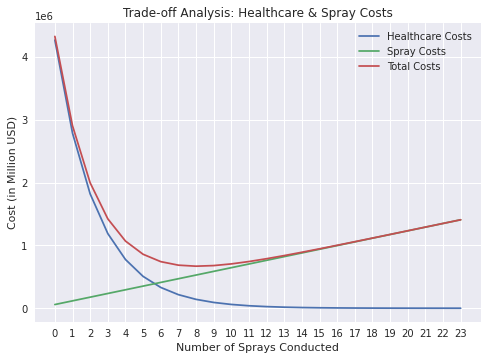

In [ ]:
def plot_CBA(num_spray = 24, uc_hc = 6317, infect_rate = 0.1, uc_sp = 0.92, mos_redux = 0.653):

#initialize
    spray_freq = []
    cost_hc = []
    cost_sp = []
    cost_tot = []

    # get initial healthcare & spray costs
    cost_healthcare, population = get_healthcare_costs(clas_feat_w_pop_onlyTraps,
                                                       uc = uc_hc,
                                                       infect_rate = infect_rate)
    cost_spray = get_spray_costs(clas_feat_w_pop_onlyTraps,
                                 uc = uc_sp)
    tot_cost = cost_healthcare + cost_spray

    for i in range(num_spray):

        tot_cost = round(cost_healthcare * (mos_redux)**(i+1) + cost_spray * (i+1),2)

        #initialize list
        spray_freq.append(i+1)
        cost_hc.append(cost_healthcare * (mos_redux)**(i+1))
        cost_sp.append(cost_spray * (i+1))
        cost_tot.append(tot_cost)



    d = {'spray_freq': spray_freq,
         'cost_hc': cost_hc,
         'cost_sp': cost_sp,
         'cost_tot': cost_tot
        }
    cost_simulate = pd.DataFrame(data=d)


    plt.plot(cost_simulate['cost_hc'], label='Healthcare Costs')
    plt.plot(cost_simulate['cost_sp'], label='Spray Costs')
    plt.plot(cost_simulate['cost_tot'], label='Total Costs')
    plt.title('Trade-off Analysis: Healthcare & Spray Costs')
    plt.xlabel('Number of Sprays Conducted')
    plt.ylabel('Cost (in Million USD)')
    plt.xticks(np.arange(0,num_spray, step=1))

    plt.legend();
    
    min_cost = round(min(cost_simulate['cost_tot']),2)
    idx = list(cost_simulate['cost_tot']).index(min(cost_simulate['cost_tot']))
    best_spray_freq = cost_simulate['spray_freq'][idx]
    print('Min Cost: ' + '$'+'{:,}'.format(min_cost))
    print('Optimal Spray Freq: ' + str(int(best_spray_freq)))
    
plot_CBA(num_spray = 24, uc_hc = 6317, infect_rate = 0.1, uc_sp = 0.92, mos_redux = 0.653)

From the plot, we see that as the number of sprays increase, the healthcare costs is reduced. However, past a certain point, we see that the cost of spraying begins to dominate. 

As such, we see that the optimal number of sprays should be approximately <b>9 times</b>. This brings the total costs down from close to <b>$637,926.94</b>. 

In [ ]:
chic_pop = pd.read_csv("../../datasets/wnv_external_data/chicago_n_population.csv")
chic_pop = chic_pop.drop(columns = 'Community Area')

pred_test = pd.read_csv("../../datasets/cleaned_data/predicted_test.csv")
hood_trap = pd.read_csv("../../datasets/original_data/train.csv")
col_to_drop = ['Date','Species','Block','Street','Latitude', 'Longitude',
 'AddressAccuracy','NumMosquitos', 'WnvPresent']
hood_trap = hood_trap.drop(columns = col_to_drop)
hood_trap = hood_trap.drop_duplicates(ignore_index = True)

def hoodsplit(row):

    temp_str = row.split(",")[0]
    temp_str = temp_str[5:]

    return temp_str

hood_trap['hoodname'] = hood_trap['Address'].map(hoodsplit)

### 4.3 Visualizing Feature Importance

In our study, we are concerned with two variables - NumMosquitos and WnvPresent. In this section, we take a look at the relative feature importance to determine a strategy for recommending sprays.

In [ ]:
regg_feat_w_pop_rank = regg_feat_w_pop.sort_values(['Feature Importance_sum','Feature Importance'], ascending = False)
regg_feat_w_pop_rank = regg_feat_w_pop_rank[['Class','Feature','Feature Importance_sum','Feature Importance']]
regg_feat_w_pop_rank = regg_feat_w_pop_rank[regg_feat_w_pop_rank['Class'] != 'Day of Week']
regg_feat_w_pop_rank = regg_feat_w_pop_rank[regg_feat_w_pop_rank['Class'] != 'Year']

In [ ]:
clas_feat_w_pop_rank = clas_feat_w_pop.sort_values(['Feature Importance_sum','Feature Importance'], ascending = False)
clas_feat_w_pop = clas_feat_w_pop[['Class','Feature','Feature Importance_sum','Feature Importance']]
clas_feat_w_pop = clas_feat_w_pop[clas_feat_w_pop['Class'] != 'Year']

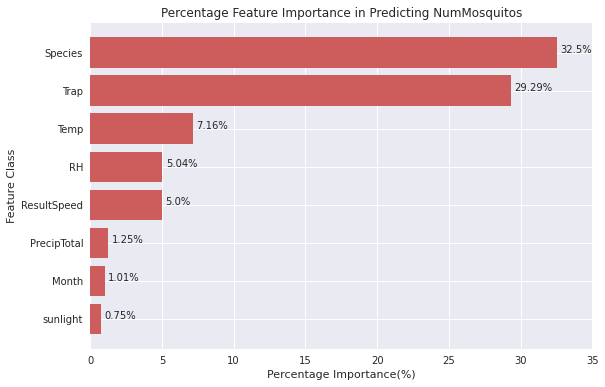

In [ ]:
plot_reg_importance_class = regg_feat_w_pop_rank[['Class','Feature Importance_sum']].drop_duplicates().sort_values(['Feature Importance_sum'], ascending = True)
plt.figure(figsize = (9,6))
plt.barh(y = plot_reg_importance_class['Class'],
        width = 100*plot_reg_importance_class['Feature Importance_sum'],
        color = 'indianred')
plt.title('Percentage Feature Importance in Predicting NumMosquitos');
plt.xlabel('Percentage Importance(%)');
plt.ylabel('Feature Class')
plt.xticks(np.arange(0,40, step=5))

reg_feat_list = list(plot_reg_importance_class['Feature Importance_sum'].values)
for i, v in enumerate(reg_feat_list):
    plt.text(100*v + 0.25, i, str(round((100*v),2))+"%")

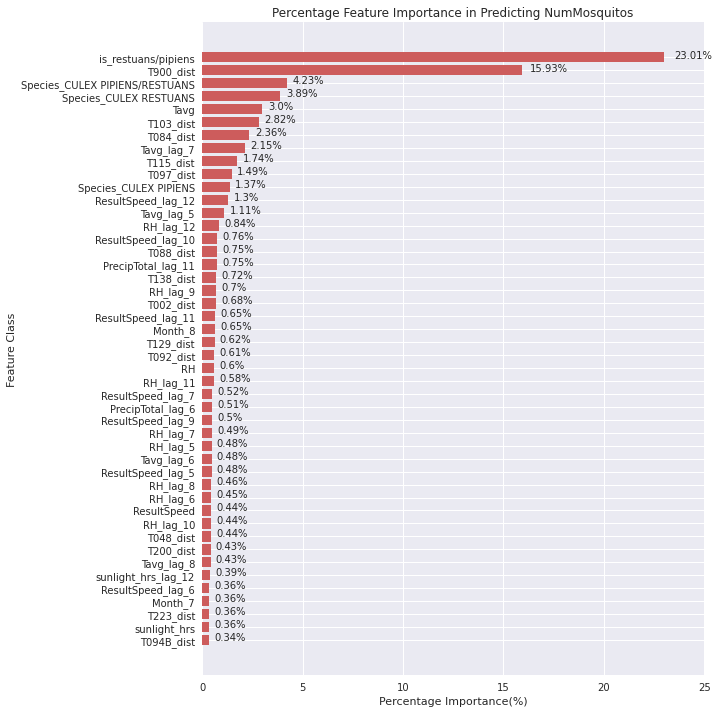

In [ ]:
plot_reg_importance_feat = regg_feat_w_pop_rank[['Feature','Feature Importance']].sort_values(['Feature Importance'], ascending = True)

plt.figure(figsize = (9,12))
plt.barh(y = plot_reg_importance_feat['Feature'],
        width = 100*plot_reg_importance_feat['Feature Importance'],
        color = 'indianred')
plt.title('Percentage Feature Importance in Predicting NumMosquitos')
plt.xlabel('Percentage Importance(%)')
plt.ylabel('Feature Class')
plt.xticks(np.arange(0,30, step=5));

reg_feat_list = list(plot_reg_importance_feat['Feature Importance'].values)
for i, v in enumerate(reg_feat_list):
    plt.text(101*v + 0.25, 0.999*i, str(round((100*v),2))+"%")

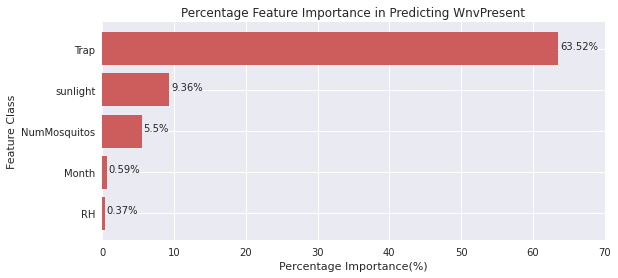

In [ ]:
plot_clasif_importance_class = clas_feat_w_pop[['Class','Feature Importance_sum']].drop_duplicates().sort_values(['Feature Importance_sum'], ascending = True)
plt.figure(figsize = (9,4))
plt.barh(y = plot_clasif_importance_class['Class'],
        width = 100*plot_clasif_importance_class['Feature Importance_sum'],color = 'indianred')
plt.title('Percentage Feature Importance in Predicting WnvPresent');
plt.xlabel('Percentage Importance(%)');
plt.ylabel('Feature Class')
plt.xticks(np.arange(0,75, step=10))

reg_feat_list = list(plot_clasif_importance_class['Feature Importance_sum'].values)
for i, v in enumerate(reg_feat_list):
    plt.text(100*v + 0.25, i, str(round((100*v),2))+"%")

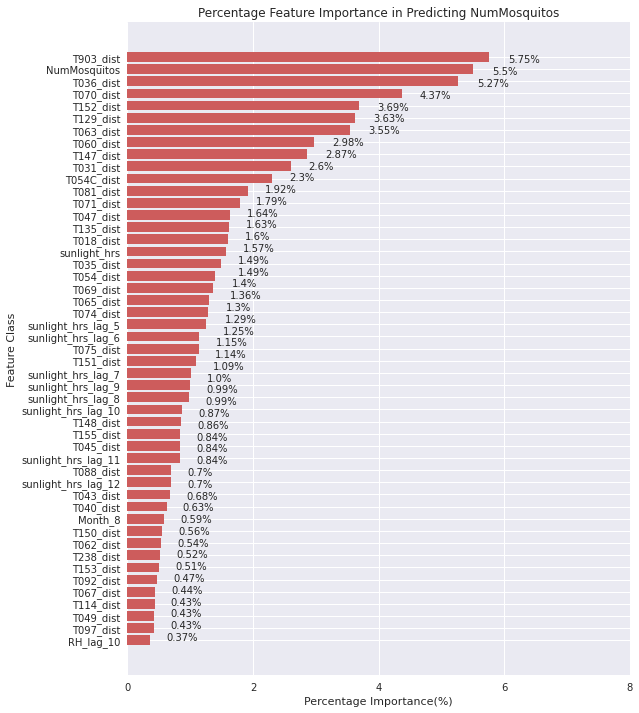

In [ ]:
plot_clasf_importance_feat = clas_feat_w_pop[['Feature','Feature Importance']].sort_values(['Feature Importance'], ascending = True)

plt.figure(figsize = (9,12))
plt.barh(y = plot_clasf_importance_feat['Feature'],
        width = 100*plot_clasf_importance_feat['Feature Importance'],
        color = 'indianred')
plt.title('Percentage Feature Importance in Predicting NumMosquitos')
plt.xlabel('Percentage Importance(%)')
plt.ylabel('Feature Class')
plt.xticks(np.arange(0,10, step=2));

reg_feat_list = list(plot_clasf_importance_feat['Feature Importance'].values)
for i, v in enumerate(reg_feat_list):
    plt.text(101*v+0.25, 0.97*i, str(round((100*v),2))+"%")

#### Analysis on Feature Importance - NumMosquitos

Based on the plots provided, we see that the species type, trap location and weather data play a significant role in determining the model's prediction on the NumMosquitos. 

While this is fairly obvious, the interesting highlight is with the features <u>"Month 7" and "Month 8"</u> being highlighted as immporant features. From this, we are now able to confidently predict that the <u>months of July and August are likely to see a sharp spike in the number of mosquitos</u>. 

#### Analysis on Feature Importance - WnvPresent

Likewise, we see that some traps <u>selected traps</u> have a significant role in determining the predictability of WNV prevalence. This signals that these traps are likely to have some inherent features which encourages/discourages the presence of the Wnv Virus. 

### Recommendations

#### 1. Preventive spraying
While the strategies may differ, one potential approach is to <u>conduct spraying in the earlier months</u> to reduce the number of mosquitos early. This should have an effect of reducing the number of mosquitos able to lay eggs in the water, and hence limit the ability of the mosquitos to have a wide explosion in numbers.

#### 2. Increase Surveillance and Data Quality

Given the poor correlation between the target and the features available, we are unable to infer any reliable insights into the trap locations. However, given the current model, more resources should be dedicated towards these traps.

For example, given the relationship with birds in the ecosystem, <u>data on migratory flight patterns and bird species should be explored to give the model more training data</u>. Also, given that humans are the direct target of the effort, some resources should be put into <u>obtaining the population data at a more granular level</u>. Combining these data points along with classical population modelling techniques, the model's accuracy can then be further improved.  
 
<!-- In view of the approximately 60 reported cases of WNV in Chicago in 2012, we can conclude that sporadic spraying is not effective in reducing the virus; a better solution would be to strategically spray households in or near affected areas, with a larger population, in a concentrated area. Considering an annual spraying expense of approximately \$1000 per household, the \$700,000 could be better allocated to offset the spraying expenses. Therefore, a community-wide funding program would potentially reduce the numbers of cases, in turn leading to reduced medical costs associated with WNV, which range between \$6,000 and \$33,000 depending on severity, as well as the cost associated with lost productivity, which ranges between \$7,500 and \$10,800. As the benefits outweigh the costs, the county should share prevention costs with the community and offset the spraying costs per household. -->

### References

1. [Sacramento County 2005 Costing](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/#:~:text=They%20included%20costs%20of%20inpatient,and%20public%20health%20agency%20costs.)
2. [Overall Cost for 2005 outbreak in Sacramento CA](https://wwwnc.cdc.gov/eid/article/16/3/09-0667_article)
3. [Mosquito Treatment Cost](https://www.callnorthwest.com/2020/05/how-much-does-a-mosquito-treatment-cost/)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4097f332-a5f7-4024-8213-3ea4e83aaea0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>